In [1]:
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.applications import InceptionV3
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.inception_v3 import preprocess_input
from IPython.display import Image, display

from tensorflow.keras.preprocessing import image

In [2]:
dir  = 'augmented_dataset'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir
)

Found 11864 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names
class_list = {}
for i, classes in enumerate(class_names):
    class_list[i] = classes

print(class_list)

{0: 'Bacterial Blight', 1: 'Blast', 2: 'Brown Spot', 3: 'Tungro'}


Class Bacterial Blight: 3168 images
Class Blast: 2880 images
Class Brown Spot: 3200 images
Class Tungro: 2616 images
11864


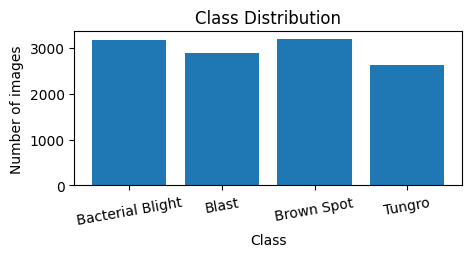

In [5]:
from collections import Counter

def distribution_class(dir):
    class_dirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    class_counts = Counter()

    for class_dir in class_dirs:
        class_path = os.path.join(dir, class_dir)
        class_counts[class_dir] = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
        
    total = 0 
    for class_name, count in class_counts.items():
        total += count
        print(f'Class {class_name}: {count} images')

    print(total)

    plt.figure(figsize=(5,2))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class Distribution')
    plt.xticks(rotation=10)
    plt.show()

distribution_class(dir)

# Parameter

In [6]:
height = 299
width = 299
batch_size = 32
learning_rate = 0.0001
epoch = 100

Train, Validation, Test Split

In [7]:
# Function to get image paths and labels
def get_image_paths_and_labels(dir):
    image_paths = []
    labels = []
    class_names = os.listdir(dir)
    for class_name in class_names:
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_name)
    return image_paths, labels

# Get all image paths and their corresponding labels
image_paths, labels = get_image_paths_and_labels(dir)

# Split the dataset into training, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.4, stratify=labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

# Function to convert lists of paths and labels to a DataFrame
def path_to_dataframe(image_paths, labels):
    return pd.DataFrame(list(zip(image_paths, labels)), columns=['filename', 'class'])

# Convert to DataFrames
train_df = path_to_dataframe(train_paths, train_labels)
val_df = path_to_dataframe(val_paths, val_labels)
test_df = path_to_dataframe(test_paths, test_labels)

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 7118 validated image filenames belonging to 4 classes.
Found 2373 validated image filenames belonging to 4 classes.
Found 2373 validated image filenames belonging to 4 classes.


# Model

In [9]:
base_model = InceptionV3(
  include_top=False,
  weights="imagenet",
  input_shape=(height, width, 3)
)

Model

In [61]:
def build_model(dense, dropout, summary = True):
  base_model.trainable = False
  
  x = base_model.output

  x = GlobalAveragePooling2D()(x)
  if dense > 0:
    x = Dense(dense, activation='relu')(x)
  x = Dropout(dropout)(x)  
  predictions = Dense(len(class_names), activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions, name= f'100_Dense_{dense}-DO_{dropout}')
  
  if summary:
    model.summary()

  model.compile(
              optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
            )
  
  return model

In [11]:
callback = keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                      )

In [12]:
def fit_model(model, epoch=50):
  history = model.fit(
              train_generator,
              verbose=1,
              epochs=epoch,
              validation_data = val_generator,
            )
  return history, model

## Train Model

In [17]:
build_0 = build_model(128, 0.5)

Model: "Dense_128-DO_0.5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                  

In [18]:
history_0, model_0 = fit_model(build_0, 100)

Epoch 1/100
223/223 [==============================] - 97s 414ms/step - loss: 0.7231 - accuracy: 0.7194 - val_loss: 0.3748 - val_accuracy: 0.8850
Epoch 2/100
223/223 [==============================] - 54s 242ms/step - loss: 0.3788 - accuracy: 0.8654 - val_loss: 0.2483 - val_accuracy: 0.9254
Epoch 3/100
223/223 [==============================] - 54s 244ms/step - loss: 0.2804 - accuracy: 0.9050 - val_loss: 0.1801 - val_accuracy: 0.9482
Epoch 4/100
223/223 [==============================] - 55s 244ms/step - loss: 0.2255 - accuracy: 0.9255 - val_loss: 0.1462 - val_accuracy: 0.9650
Epoch 5/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1821 - accuracy: 0.9451 - val_loss: 0.1258 - val_accuracy: 0.9642
Epoch 6/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1518 - accuracy: 0.9536 - val_loss: 0.1009 - val_accuracy: 0.9751
Epoch 7/100
223/223 [==============================] - 55s 246ms/step - loss: 0.1280 - accuracy: 0.9619 - val_loss: 0.0902 -

In [19]:
model_1 = build_model(64, 0.5)

Model: "Dense_64-DO_0.5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                   

In [22]:
history_1, model_1 = fit_model(model_1, 100)

Epoch 1/100
223/223 [==============================] - 54s 242ms/step - loss: 0.4041 - accuracy: 0.8539 - val_loss: 0.2736 - val_accuracy: 0.9094
Epoch 2/100
223/223 [==============================] - 55s 245ms/step - loss: 0.3182 - accuracy: 0.8929 - val_loss: 0.2203 - val_accuracy: 0.9334
Epoch 3/100
223/223 [==============================] - 55s 246ms/step - loss: 0.2755 - accuracy: 0.9070 - val_loss: 0.1786 - val_accuracy: 0.9503
Epoch 4/100
223/223 [==============================] - 55s 247ms/step - loss: 0.2354 - accuracy: 0.9234 - val_loss: 0.1510 - val_accuracy: 0.9600
Epoch 5/100
223/223 [==============================] - 55s 248ms/step - loss: 0.2062 - accuracy: 0.9348 - val_loss: 0.1336 - val_accuracy: 0.9659
Epoch 6/100
223/223 [==============================] - 55s 248ms/step - loss: 0.1809 - accuracy: 0.9421 - val_loss: 0.1216 - val_accuracy: 0.9654
Epoch 7/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1594 - accuracy: 0.9513 - val_loss: 0.1060 -

In [23]:
model_2 = build_model(0, 0.5)

Model: "Dense_0-DO_0.5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                    

In [24]:
history_2, model_2 = fit_model(model_2, 100)

Epoch 1/100
223/223 [==============================] - 61s 255ms/step - loss: 1.1356 - accuracy: 0.5117 - val_loss: 0.7435 - val_accuracy: 0.7278
Epoch 2/100
223/223 [==============================] - 54s 243ms/step - loss: 0.7657 - accuracy: 0.7015 - val_loss: 0.5569 - val_accuracy: 0.8057
Epoch 3/100
223/223 [==============================] - 54s 242ms/step - loss: 0.6204 - accuracy: 0.7568 - val_loss: 0.4657 - val_accuracy: 0.8496
Epoch 4/100
223/223 [==============================] - 54s 242ms/step - loss: 0.5293 - accuracy: 0.8026 - val_loss: 0.4072 - val_accuracy: 0.8643
Epoch 5/100
223/223 [==============================] - 54s 243ms/step - loss: 0.4787 - accuracy: 0.8214 - val_loss: 0.3653 - val_accuracy: 0.8799
Epoch 6/100
223/223 [==============================] - 54s 243ms/step - loss: 0.4272 - accuracy: 0.8439 - val_loss: 0.3314 - val_accuracy: 0.8976
Epoch 7/100
223/223 [==============================] - 54s 243ms/step - loss: 0.3931 - accuracy: 0.8594 - val_loss: 0.3059 -

In [33]:
model_3 = build_model(128, 0.3)

Model: "Dense_128-DO_0.3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                  

In [34]:
history_3, model_3 = fit_model(model_3, 100)

Epoch 1/100
223/223 [==============================] - 93s 391ms/step - loss: 0.6388 - accuracy: 0.7532 - val_loss: 0.3264 - val_accuracy: 0.9027
Epoch 2/100
223/223 [==============================] - 54s 241ms/step - loss: 0.3123 - accuracy: 0.8949 - val_loss: 0.2147 - val_accuracy: 0.9423
Epoch 3/100
223/223 [==============================] - 54s 242ms/step - loss: 0.2211 - accuracy: 0.9291 - val_loss: 0.1644 - val_accuracy: 0.9570
Epoch 4/100
223/223 [==============================] - 54s 242ms/step - loss: 0.1742 - accuracy: 0.9483 - val_loss: 0.1285 - val_accuracy: 0.9646
Epoch 5/100
223/223 [==============================] - 54s 242ms/step - loss: 0.1401 - accuracy: 0.9586 - val_loss: 0.1101 - val_accuracy: 0.9730
Epoch 6/100
223/223 [==============================] - 54s 243ms/step - loss: 0.1173 - accuracy: 0.9681 - val_loss: 0.0990 - val_accuracy: 0.9751
Epoch 7/100
223/223 [==============================] - 54s 243ms/step - loss: 0.0963 - accuracy: 0.9740 - val_loss: 0.0805 -

In [62]:
model_4 = build_model(0, 0.3)

Model: "100_Dense_0-DO_0.3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                

In [63]:
history_4, model_4 = fit_model(model_4, 100)

Epoch 1/100
223/223 [==============================] - 101s 428ms/step - loss: 1.1022 - accuracy: 0.5310 - val_loss: 0.7380 - val_accuracy: 0.7539
Epoch 2/100
223/223 [==============================] - 54s 244ms/step - loss: 0.6938 - accuracy: 0.7421 - val_loss: 0.5401 - val_accuracy: 0.8150
Epoch 3/100
223/223 [==============================] - 54s 243ms/step - loss: 0.5422 - accuracy: 0.8044 - val_loss: 0.4435 - val_accuracy: 0.8592
Epoch 4/100
223/223 [==============================] - 52s 232ms/step - loss: 0.4608 - accuracy: 0.8370 - val_loss: 0.3805 - val_accuracy: 0.8841
Epoch 5/100
223/223 [==============================] - 52s 231ms/step - loss: 0.4072 - accuracy: 0.8602 - val_loss: 0.3368 - val_accuracy: 0.9014
Epoch 6/100
223/223 [==============================] - 51s 230ms/step - loss: 0.3670 - accuracy: 0.8776 - val_loss: 0.3040 - val_accuracy: 0.9102
Epoch 7/100
223/223 [==============================] - 52s 231ms/step - loss: 0.3373 - accuracy: 0.8841 - val_loss: 0.2773 

In [64]:
build_5 = build_model(64, 0.3)

Model: "100_Dense_64-DO_0.3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [65]:
history_5, model_5 = fit_model(build_5, 100)

Epoch 1/100
223/223 [==============================] - 60s 244ms/step - loss: 0.7651 - accuracy: 0.7046 - val_loss: 0.4023 - val_accuracy: 0.8761
Epoch 2/100
223/223 [==============================] - 53s 239ms/step - loss: 0.3988 - accuracy: 0.8584 - val_loss: 0.2692 - val_accuracy: 0.9204
Epoch 3/100
223/223 [==============================] - 84s 377ms/step - loss: 0.2951 - accuracy: 0.9004 - val_loss: 0.2012 - val_accuracy: 0.9435
Epoch 4/100
223/223 [==============================] - 55s 248ms/step - loss: 0.2287 - accuracy: 0.9244 - val_loss: 0.1610 - val_accuracy: 0.9545
Epoch 5/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1843 - accuracy: 0.9432 - val_loss: 0.1358 - val_accuracy: 0.9659
Epoch 6/100
223/223 [==============================] - 55s 244ms/step - loss: 0.1609 - accuracy: 0.9487 - val_loss: 0.1170 - val_accuracy: 0.9713
Epoch 7/100
223/223 [==============================] - 54s 243ms/step - loss: 0.1323 - accuracy: 0.9612 - val_loss: 0.1028 -

In [66]:
build_6 = build_model(64, 0.4)

Model: "100_Dense_64-DO_0.4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [67]:
history_6, model_6 = fit_model(build_6, 100)

Epoch 1/100
223/223 [==============================] - 60s 251ms/step - loss: 0.7982 - accuracy: 0.6897 - val_loss: 0.4105 - val_accuracy: 0.8761
Epoch 2/100
223/223 [==============================] - 54s 244ms/step - loss: 0.4182 - accuracy: 0.8556 - val_loss: 0.2738 - val_accuracy: 0.9107
Epoch 3/100
223/223 [==============================] - 55s 245ms/step - loss: 0.3137 - accuracy: 0.8960 - val_loss: 0.2061 - val_accuracy: 0.9440
Epoch 4/100
223/223 [==============================] - 55s 245ms/step - loss: 0.2509 - accuracy: 0.9201 - val_loss: 0.1632 - val_accuracy: 0.9545
Epoch 5/100
223/223 [==============================] - 55s 245ms/step - loss: 0.2175 - accuracy: 0.9292 - val_loss: 0.1422 - val_accuracy: 0.9642
Epoch 6/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1815 - accuracy: 0.9444 - val_loss: 0.1206 - val_accuracy: 0.9684
Epoch 7/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1576 - accuracy: 0.9529 - val_loss: 0.1054 -

In [68]:
build_7 = build_model(128, 0.4)

Model: "100_Dense_128-DO_0.4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                              

In [69]:
history_7, model_7 = fit_model(build_7, 100)

Epoch 1/100
223/223 [==============================] - 60s 251ms/step - loss: 0.6996 - accuracy: 0.7246 - val_loss: 0.3480 - val_accuracy: 0.8942
Epoch 2/100
223/223 [==============================] - 54s 244ms/step - loss: 0.3442 - accuracy: 0.8845 - val_loss: 0.2272 - val_accuracy: 0.9393
Epoch 3/100
223/223 [==============================] - 54s 244ms/step - loss: 0.2544 - accuracy: 0.9153 - val_loss: 0.1691 - val_accuracy: 0.9595
Epoch 4/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1932 - accuracy: 0.9372 - val_loss: 0.1342 - val_accuracy: 0.9676
Epoch 5/100
223/223 [==============================] - 54s 244ms/step - loss: 0.1609 - accuracy: 0.9504 - val_loss: 0.1146 - val_accuracy: 0.9701
Epoch 6/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1313 - accuracy: 0.9629 - val_loss: 0.0934 - val_accuracy: 0.9777
Epoch 7/100
223/223 [==============================] - 55s 245ms/step - loss: 0.1121 - accuracy: 0.9681 - val_loss: 0.0828 -

In [87]:
build_8 = build_model(0, 0.4)

Model: "100_Dense_0-DO_0.4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                

In [88]:
history_8, model_8 = fit_model(build_8, 100)

Epoch 1/100
223/223 [==============================] - 87s 368ms/step - loss: 1.1401 - accuracy: 0.5001 - val_loss: 0.7296 - val_accuracy: 0.7585
Epoch 2/100
223/223 [==============================] - 54s 243ms/step - loss: 0.7153 - accuracy: 0.7246 - val_loss: 0.5394 - val_accuracy: 0.8150
Epoch 3/100
223/223 [==============================] - 54s 243ms/step - loss: 0.5738 - accuracy: 0.7901 - val_loss: 0.4448 - val_accuracy: 0.8550
Epoch 4/100
223/223 [==============================] - 55s 245ms/step - loss: 0.4938 - accuracy: 0.8167 - val_loss: 0.3835 - val_accuracy: 0.8757
Epoch 5/100
223/223 [==============================] - 55s 246ms/step - loss: 0.4332 - accuracy: 0.8459 - val_loss: 0.3412 - val_accuracy: 0.8925
Epoch 6/100
223/223 [==============================] - 54s 244ms/step - loss: 0.3950 - accuracy: 0.8622 - val_loss: 0.3100 - val_accuracy: 0.9014
Epoch 7/100
223/223 [==============================] - 55s 245ms/step - loss: 0.3641 - accuracy: 0.8743 - val_loss: 0.2862 -

# Evaluation

## Metrics

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

def evaluation(model, plot=True, report = True, save=True):
  title = model.name
  heading = f'\n<==== {title} ====>'
  print(heading)
  
  predictions = model.predict(test_generator)
  y_true = test_generator.classes
  y_pred_classes = np.argmax(predictions, axis=1)
  
  if plot:
    conf_matrix = confusion_matrix(y_pred_classes, y_true)
    mat = plt
    mat.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    mat.ylabel('Actual')
    mat.xlabel('Predicted')
    mat.suptitle(title, fontsize=11)    
    mat.savefig('report/confusion_matrix/'+title.replace(".", ",")+'_matrix.png')
    mat.show()
    
  if report:
    test_loss, test_acc = model.evaluate(test_generator)
    acc_loss = f'Test accuracy: {round(test_acc*100,2)}%, test loss: {round(test_loss*100,2)}%'
    print(acc_loss)
    
    target_names = list(test_generator.class_indices.keys())
    clas_report = classification_report(y_true, y_pred_classes, target_names=target_names)
    print(clas_report)
 
  if save:
    dis = plt
    fig, ax = dis.subplots(figsize=(8, 4))
    
    ax.text(0.1, 1, f"<==== {title} ====>", fontsize=11, ha='left')
    ax.text(0.1, 0.85, acc_loss, fontsize=10, ha='left')
    ax.text(0.1, 0.15, "Classification Report: \n" + clas_report, fontsize=10, ha='left', family='monospace')
    ax.axis('off')
    
    dis.savefig(f"report/classification_reports/{title}.png")
    dis.close(fig)

## Train graph

In [45]:
def train_graph(history, title, save = True):
  fig , ax = plt.subplots(1,2)
  train_acc = history['accuracy']
  train_loss = history['loss']
  val_acc = history['val_accuracy']
  val_loss = history['val_loss']
  fig.set_size_inches(9,3)

  ax[0].plot(train_acc)
  ax[0].plot(val_acc)
  ax[0].set_title('Training Accuracy vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'],)

  ax[1].plot(train_loss)
  ax[1].plot(val_loss)
  ax[1].set_title('Training Loss vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'])

  # Add a title for the entire figure
  fig.suptitle(title, fontsize=11)
  plt.subplots_adjust(top=0.85)
  if save:
    plt.savefig('report/train_graph/'+title.replace(".", ",")+'_graph')
  plt.show()

In [46]:
def save_model(model):  
  filename = f'model/epoch/{model.name}.keras'
  model.save(filename)

import pickle

def save_history(name, history):
  with open(f'model/history/{name}_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    
def load_history(name):
  with open(name, 'rb') as file:
      return pickle.load(file)

## Report


<==== 100_Dense_0-DO_0.4 ====>
75/75 [==============================] - 24s 284ms/step


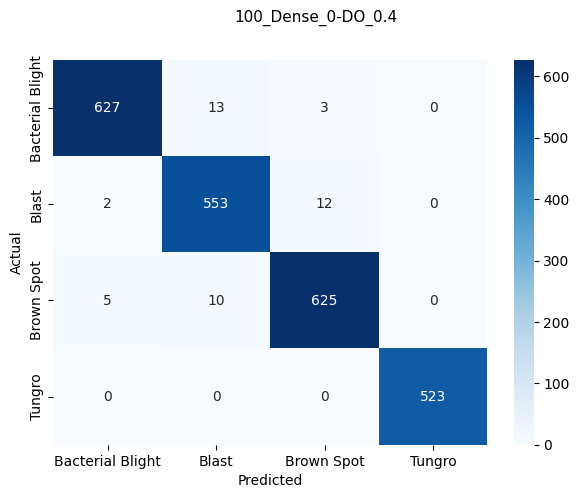

75/75 [==============================] - 14s 182ms/step - loss: 0.0711 - accuracy: 0.9810
Test accuracy: 98.1%, test loss: 7.11%
                  precision    recall  f1-score   support

Bacterial Blight       0.98      0.99      0.98       634
           Blast       0.98      0.96      0.97       576
      Brown Spot       0.98      0.98      0.98       640
          Tungro       1.00      1.00      1.00       523

        accuracy                           0.98      2373
       macro avg       0.98      0.98      0.98      2373
    weighted avg       0.98      0.98      0.98      2373



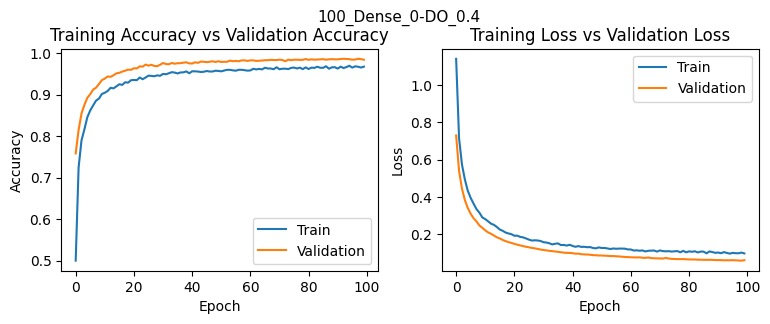

In [89]:
# model = load_model('model/dense/Dense_228-DO_2.3.h5')
# his =  load_history('model/history/Dense_228-DO_2.5_history.pkl')
# for i in [2,2,2]:
# his = [history_4, history_5, history_6, history_7]
# mod = [model_4, model_5, model_6, model_7]
# for i in range(len(mod)):
  # print(model_8.name)
  # print(his[i])
  
evaluation(model_8)
save_model(model_8)
train_graph(history_8.history, model_8.name)
save_history(model_8.name, history_8)


## Predict


In [ ]:
file = 'model/(11-06_11-54)99.494.h5'
this_model = load_model(file)

In [71]:
class_names = {0: 'Bacterial Blight', 1: 'Blast', 2: 'Brown Spot', 3: 'Tungro'}
height = 299
width = 299

In [70]:
def img_to_array(img_path):
  img = image.load_img(img_path, target_size=(height, width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  return img_array

In [ ]:
def get_prediction(img_path, this_model, class_names):
    img_array = img_to_array(img_path)
   
    predictions = this_model.predict(img_array, verbose=1)
    predicted_index = np.argmax(predictions)

    confidence_score = round(predictions[0][predicted_index] * 100, 3)

    predicted_class = class_names[predicted_index]
    return predicted_class, confidence_score


In [ ]:
img_path = 'dataset/Tungro/TUNGRO1_003.jpg'

predicted_class, confidence_score = get_prediction(img_path, this_model, class_names)
print(f'Predicted class: {predicted_class} with confidence score: {confidence_score} %')


# GradCAM

In [72]:
# fungsi mendapatkan heatmap gradcam
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # variabel grad_model digunakan untuk
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    return heatmap, preds

In [73]:
def get_heatmap(img_path, this_model, pred_id=None, show=False):
  last_conv_layer_name = "mixed10"

  this_model.layers[-1].activation = None
  
  img_arr = img_to_array(img_path)
  heatmap, preds = make_gradcam_heatmap(img_arr, this_model, last_conv_layer_name, pred_id)

  pred_idx = np.argmax(preds[0])
  confidence_level = tf.reduce_max(tf.nn.softmax(preds[0])).numpy()
  score = round(confidence_level * 100, 3)
  
  label = f"{class_names[pred_idx]}, {score}%"
  if show:
    plt.matshow(heatmap)
    plt.show()
  return heatmap, label


In [74]:
from PIL import Image as PilImage, ImageDraw, ImageFont
import matplotlib as mpl 

def save_and_display_gradcam(img_path, heatmap, max_width=None, cam_path="result", alpha=0.5, label=None, show=True):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path+'.jpg')

    if label != None:
        image_with_text = PilImage.open(cam_path+'.jpg')
        fs = image_with_text.width//18
        draw = ImageDraw.Draw(image_with_text)
        font = ImageFont.truetype("arial.ttf", fs)
        text_size = draw.textbbox((0, 0), label, font=font)
        text_position = (0,0)
        draw.rectangle((text_position[0], text_position[1], text_position[0] + text_size[2], text_position[1] + text_size[3]), fill="black")
        draw.text(text_position, label, fill="white", font=font)
        image_with_text.save(cam_path+'.jpg')
    if show:
        display(Image(filename=cam_path+'.jpg', width=max_width))


## Predict and show GradCAM

In [86]:
img = ['dataset/Bacterial Blight/BACTERAILBLIGHT3_024.jpg','dataset/Bacterial Blight/BACTERIALBLIGHT2_204.JPG','dataset/Bacterial Blight/BACTERIALBLIGHT2_192.jpg','dataset/Blast/BLAST9_139.JPG','dataset/Blast/BLAST1_002.jpg','dataset/Blast/BLAST9_107.jpg','dataset/Brown Spot/brownspot_orig_028.jpg','dataset/Brown Spot/BROWNSPOT7_195.jpg','dataset/Tungro/TUNGRO1_008.jpg','dataset/Tungro/TUNGRO5_193.JPG', 'dataset/Tungro/TUNGRO5_113.jpg','dataset/Tungro/TUNGRO1_028.jpg','dataset/Bacterial Blight/BACTERAILBLIGHT3_036.jpg','dataset/Bacterial Blight/BACTERAILBLIGHT3_043.jpg','dataset/Blast/BLAST1_030.jpg','dataset/Blast/BLAST9_154.jpg','dataset/Blast/BLAST9_157.jpg','dataset/Brown Spot/brownspot_orig_040.jpg','dataset/Brown Spot/BROWNSPOT7_040.jpg','dataset/Tungro/TUNGRO1_004.jpg','dataset/Tungro/TUNGRO5_191.JPG','dataset/Tungro/TUNGRO4_138.JPG']
d12803 = load_model('model/dense/100_Dense_128-DO_0.3.keras')
# print(f'...{model.name}')
import random as rd
for c in img:
  num = rd.randint(1,120)
  name = os.path.basename(os.path.dirname(c))
  
  heatmap, label = get_heatmap(c, d12803)
  save_and_display_gradcam(c, heatmap, 300, alpha=0.7, cam_path=f'gradcam/{name}/{num}', show=False)

# heatmap, label = get_heatmap('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', model_0)
# save_and_display_gradcam('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', heatmap, 300, alpha=0.7)
# heatmap, label = get_heatmap('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', model_1)
# save_and_display_gradcam('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', heatmap, 300, alpha=0.7)

# Test

In [ ]:
test_dir = 'img/test'
check = datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# model = load_model('model/dense/Dense_128-DO_0.5.h5')
# predictions = model.predict(check)
# y_pred_classes = np.argmax(predictions, axis=1)
# y_true = check.classes
test_loss, test_acc = model.evaluate(check)
# Print classification report
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))

Found 19 images belonging to 4 classes.
1/1 [==============================] - 2s 2s/step - loss: 7.6450 - accuracy: 0.5263
                  precision    recall  f1-score   support

Bacterial Blight       0.50      0.75      0.60         4
           Blast       0.29      0.50      0.36         4
      Brown Spot       1.00      0.43      0.60         7
          Tungro       0.67      0.50      0.57         4

        accuracy                           0.53        19
       macro avg       0.61      0.54      0.53        19
    weighted avg       0.67      0.53      0.54        19

